In [70]:
import os
import random

# 데이터 처리 및 연산
import numpy as np
import pandas as pd
from scipy.stats import shapiro, normaltest

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

# Scikit-learn (전처리, 모델링, 평가)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    precision_recall_curve, 
    average_precision_score, 
    roc_curve, 
    roc_auc_score
)

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# 한글 폰트 경로 설정 
font_path = 'C:/Windows/Fonts/malgun.ttf' 
font_prop = font_manager.FontProperties(fname=font_path, size=12)
# 맑은 고딕 폰트 설정
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family=font_prop.get_name())

In [71]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed = 52
seed_everything(seed)


In [82]:
# 타임시리즈 시퀀스 생성 함수: create_lstm_sequences
def create_lstm_sequences(df, time_steps=1):
    """
    Parameters:
    df : 입력 데이터프레임 (일 단위 데이터)
    time_steps : 시퀀스 길이 (time steps) = 1
    
    Returns:
    numpy array: (samples, time_steps, features)
    """
    # 1. 날짜 기준 정렬
    df = df.sort_values('meter_dd').reset_index(drop=True)
    
    # 2. 특징 추출: 전력 사용량 + 계절 + 주중주말
    power_cols = [col for col in df.columns if col.startswith('elcp_use_')]
    features = power_cols + ['season', 'weekd_weekend']  # 인코딩된 컬럼명 추가
    data = df[features].values
    
    # 3. 시퀀스 생성
    sequences = []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        
    return np.array(sequences)

# 함수 실행 예시
sequenced_data = create_lstm_sequences(preprocessed_data)
print(f"생성된 시퀀스 형태: {sequenced_data.shape}")
print(f"특징 개수: {sequenced_data.shape[-1]} (전력사용량 {len([col for col in preprocessed_data.columns if col.startswith('elcp_use_')])}개 + 계절 1 + 주중/주말 1)")

생성된 시퀀스 형태: (1096, 1, 98)
특징 개수: 98 (전력사용량 96개 + 계절 1 + 주중/주말 1)


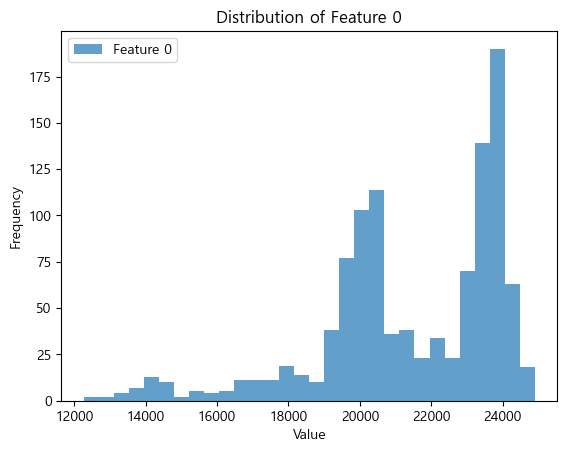

3.033653639209429e-27
3.410744614083566e-27
3.023047282454997e-27
2.6231683414147555e-27
2.582888325455398e-27
2.142252166169974e-27
1.8780055970899502e-27
1.667833481345062e-27
1.811726002109954e-27
1.7763038643993778e-27
1.5532628181625133e-27
1.465893950163701e-27
1.5499783825607007e-27
1.5394295192549247e-27
1.448730089731673e-27
1.6223717774385e-27
1.5147118523210332e-27
1.3106940198177693e-27
1.2765442340810916e-27
1.2177130887974172e-27
1.1236152285122129e-27
9.202604755703644e-28
7.149055042335839e-28
4.054951622017303e-28
2.755343439624843e-28
2.1303057791973616e-28
2.0798986918270177e-28
2.596252631714095e-28
2.832084507171947e-28
4.6865041590408405e-28
7.5352522564975e-28
1.3351407150765717e-27
1.5447319522887004e-27
1.769041060968883e-27
1.949864012942365e-27
2.2780587768039367e-27
2.9974483191117465e-27
5.894386316736143e-27
7.97876225392931e-27
2.0912211678525165e-28
1.208036501112394e-26
1.242274433831455e-26
1.564022178813325e-26
1.8604311435198525e-26
2.206800924391972

In [83]:
#데이터 분포 확인 
# 데이터셋 (1096, 1, 98)
data = sequenced_data.reshape(-1, 98)

# 정규성 검사를 수행하는 함수
def check_normality(data):
    results = {}
    for feature_idx in range(data.shape[1]):  # 각 특성별로 검사
        feature_data = data[:, feature_idx]

        # Shapiro-Wilk Test
        shapiro_stat, shapiro_p = shapiro(feature_data)

        # D'Agostino and Pearson's Test
        dagostino_stat, dagostino_p = normaltest(feature_data)

        results[f"Feature {feature_idx}"] = {
            "Shapiro-Wilk p-value": shapiro_p,
            "D'Agostino p-value": dagostino_p
        }

    return results

# 정규성 검사 수행
normality_results = check_normality(data)

# 첫 번째 특성의 분포 시각화
plt.hist(data[:, 0], bins=30, alpha=0.7, label='Feature 0')
plt.title('Distribution of Feature 0')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 결과 출력
for idx in range(len(normality_results)):
    print(normality_results[f"Feature {idx}"]["Shapiro-Wilk p-value"])

Detected anomalies: 55


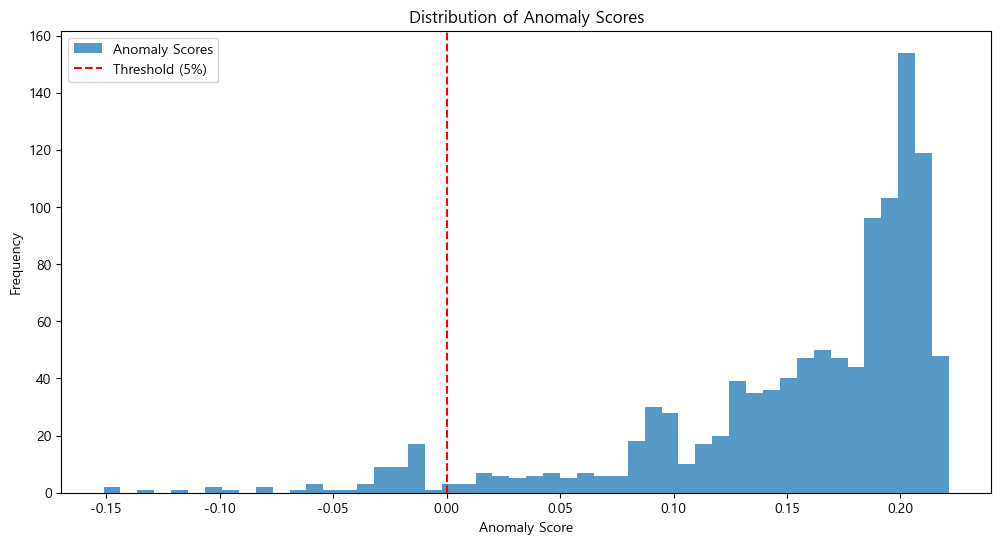

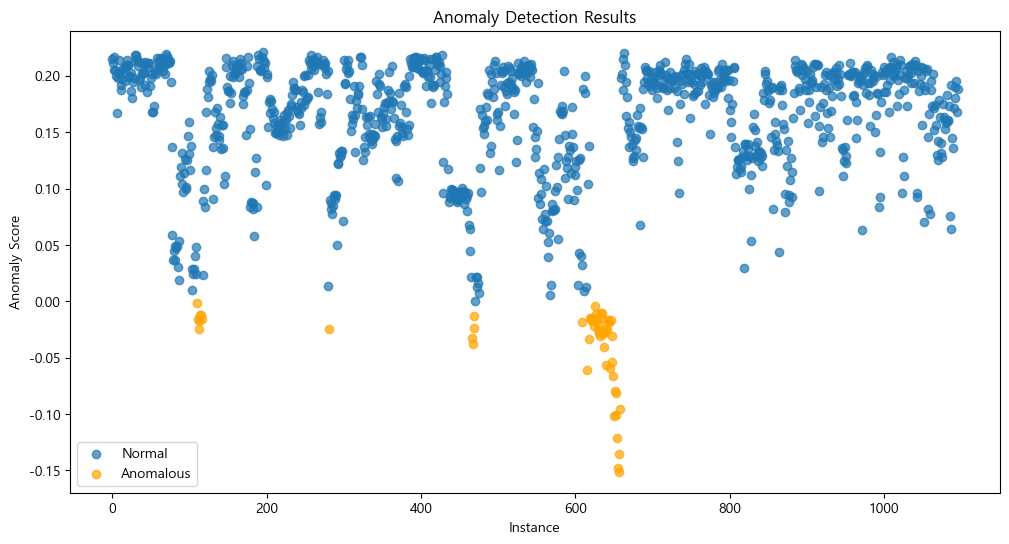

In [84]:
#IF로 데이터셋 정상치/이상치 분류 및 결과 확인

# 데이터 준비
data = sequenced_data.reshape(-1, sequenced_data.shape[2])

# Isolation Forest 모델 생성 및 학습, contamination을 0.03로 설정
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=seed)
iso_forest.fit(data)

# 이상치 점수 계산 및 분류
anomaly_scores = iso_forest.decision_function(data)  # 이상치 점수 계산
anomalies = iso_forest.predict(data)  # 이상치 분류 (-1: 이상치, 1: 정상치)

# 결과를 데이터프레임으로 저장
results_df = pd.DataFrame({
    'Instance': np.arange(len(data)),
    'Anomaly_Score': anomaly_scores,
    'Anomaly': anomalies
})

# 이상치 개수 확인
print("Detected anomalies:", (results_df['Anomaly'] == -1).sum())

# 시각화: 이상치 점수 분포
plt.figure(figsize=(12, 6))
plt.hist(results_df['Anomaly_Score'], bins=50, alpha=0.75, label='Anomaly Scores')
plt.axvline(x=results_df['Anomaly_Score'].quantile(0.05), color='r', linestyle='--', label='Threshold (5%)')
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 시각화: 정상치와 이상치 분포 비교
plt.figure(figsize=(12, 6))
normal = results_df[results_df['Anomaly'] == 1]
anomalous = results_df[results_df['Anomaly'] == -1]

plt.scatter(normal['Instance'], normal['Anomaly_Score'], label='Normal', alpha=0.7)
plt.scatter(anomalous['Instance'], anomalous['Anomaly_Score'], label='Anomalous', alpha=0.7, color='orange')
plt.title("Anomaly Detection Results")
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

In [85]:
# 1. 시퀀스 단위 레이블 생성
# 이상치 예측 결과를 원본 시퀀스 형태로 재구성
sequence_anomalies = anomalies.reshape(sequenced_data.shape[0], sequenced_data.shape[1])

# 2. 시퀀스 레이블링 (시퀀스 내 이상치 존재 여부)
sequence_labels = np.where(
    (sequence_anomalies == -1).any(axis=1), 1, 0  # 시퀀스 내 1개 이상 이상치 존재 시 1
)

# 3. 데이터셋 분리
# 정상 데이터셋 (형태: [samples, 1, 98])
normal_seq = sequenced_data[sequence_labels == 0]
# 이상 데이터셋 (형태: [samples, 1, 98])
anomaly_seq = sequenced_data[sequence_labels == 1]

# 4. LSTM 입력용 레이블 생성
labels_seq = sequence_labels.reshape(-1, 1)  # (samples, 1)

# 5. 분리 결과 검증
print(f"""
[데이터 분리 결과]
정상 시퀀스: {normal_seq.shape} (레이블 0)
이상 시퀀스: {anomaly_seq.shape} (레이블 1)
레이블 분포: {np.unique(sequence_labels, return_counts=True)}
""")

labels_seq.shape


[데이터 분리 결과]
정상 시퀀스: (1041, 1, 98) (레이블 0)
이상 시퀀스: (55, 1, 98) (레이블 1)
레이블 분포: (array([0, 1]), array([1041,   55]))



(1096, 1)

In [86]:
# 정상 데이터의 레이블이 모두 0인지 확인
print("정상 데이터 레이블 검증:", np.all(labels_seq[sequence_labels == 0] == 0))

# 이상 데이터의 레이블이 모두 1인지 확인
print("이상 데이터 레이블 검증:", np.all(labels_seq[sequence_labels == 1] == 1))

정상 데이터 레이블 검증: True
이상 데이터 레이블 검증: True


In [88]:
#MinMax 스케일링
#이유는 이상치가 정상치에 비해 적어서, 원래 분포를 유지함

# 3D → 2D 변환
def reshape_for_scaling(data):
    return data.reshape(data.shape[0], -1)

# Train 데이터로 scaler 학습
scaler = MinMaxScaler()
scaler.fit(reshape_for_scaling(train_normal))

# 모든 데이터셋 변환
train_scaled = scaler.transform(reshape_for_scaling(train_normal)).reshape(train_normal.shape)
valid_scaled = scaler.transform(reshape_for_scaling(valid_data)).reshape(valid_data.shape)
test_scaled = scaler.transform(reshape_for_scaling(test_data)).reshape(test_data.shape)

print(train_scaled.shape)
print(valid_scaled.shape)
print(test_scaled.shape)

# 데이터셋 저장
np.save('train_scaled.npy', train_scaled)
np.save('valid_scaled.npy', valid_scaled)
np.save('test_scaled.npy', test_scaled)

(728, 1, 98)
(183, 1, 98)
(185, 1, 98)


In [89]:
# 1. Train 라벨 (정상 데이터만 포함)
train_labels = np.zeros(train_normal.shape[0], dtype=int)

# 2. Valid 라벨 (정상:valid_norm_size, 이상:valid_anorm_size)
valid_normal_size = valid_scaled.shape[0] - valid_anomaly.shape[0]
valid_labels = np.concatenate([
    np.zeros(valid_normal_size, dtype=int),
    np.ones(valid_anomaly.shape[0], dtype=int)
])

# 3. Test 라벨 (정상:test_norm_size, 이상:test_anorm_size)
test_normal_size = test_scaled.shape[0] - test_anomaly.shape[0]
test_labels = np.concatenate([
    np.zeros(test_normal_size, dtype=int),
    np.ones(test_anomaly.shape[0], dtype=int)
])

# 4. 분포 확인
print(f"""
[레이블 분포]
Train: 100% 정상 ({len(train_labels)}개)
Valid: {valid_normal_size} 정상 + {valid_anomaly.shape[0]} 이상 → {valid_normal_size/(valid_normal_size+valid_anomaly.shape[0])*100:.1f}% 정상
Test: {test_normal_size} 정상 + {test_anomaly.shape[0]} 이상 → {test_normal_size/(test_normal_size+test_anomaly.shape[0])*100:.1f}% 정상
""")


[레이블 분포]
Train: 100% 정상 (728개)
Valid: 156 정상 + 27 이상 → 85.2% 정상
Test: 157 정상 + 28 이상 → 84.9% 정상



In [90]:
# valid, test 데이터 섞기(라벨 포함)
def shuffle_data(data, labels,seed = seed):
    np.random.seed(seed)
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    return data[indices], labels[indices]

# 섞기 실행
shuffled_test_scaled, shuffled_test_labels = shuffle_data(test_scaled, test_labels)
shuffled_val_scaled, shuffled_val_labels = shuffle_data(valid_scaled, valid_labels)

# 결과 확인
print(shuffled_test_scaled.shape)  # 예시: (500, 1, 98)
print(shuffled_test_labels.shape)  # 예시: (500,)
print(shuffled_val_scaled.shape)  # 예시: (500, 1, 98)
print(shuffled_val_labels.shape)  # 예시: (500,)

(185, 1, 98)
(185,)
(183, 1, 98)
(183,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1, 98)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1, 64)               │          41,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1, 32)               │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 1, 98)               │           6,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,722 (370.01 KB)

 Trainable params: 94,722 (370.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.4483 - val_loss: 0.3437
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1801 - val_loss: 0.0676
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0406 - val_loss: 0.0352
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.0223
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_loss: 0.0216
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0216
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - val_loss: 0.0216
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0215
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_loss: 0.0213
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0211
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0209
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

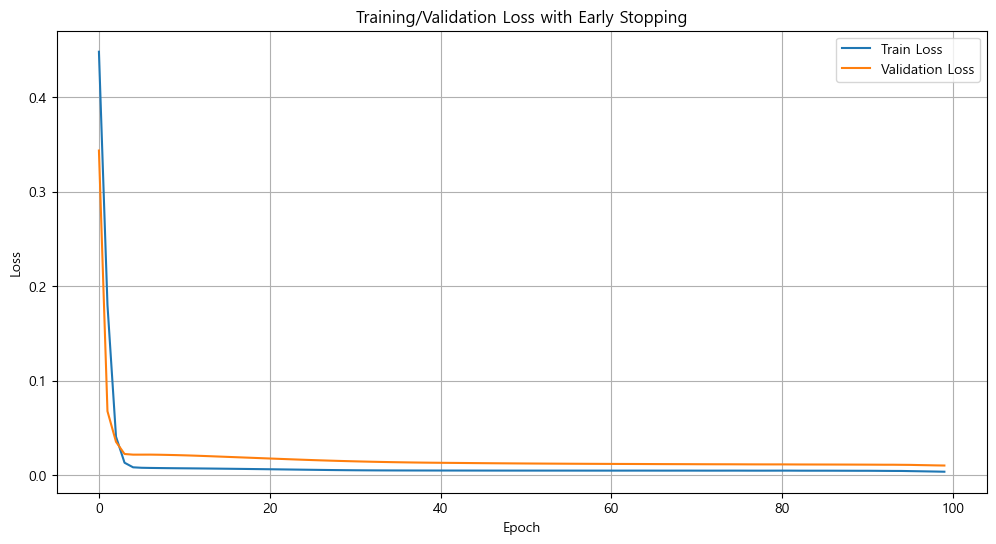

In [91]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. 모델 빌드 함수 (변경 없음)
def build_lstmae(time_steps=1, features=98):
    params = {
        'learning_rate': 0.001,
        'lstm1_units': 64,
        'lstm2_units': 32,
        'dense_units': 32,
        'dropout_rate': 0.0,
        'batch_size': 32,
        'optimizer': 'adam'
    }

    inputs = tf.keras.Input(shape=(time_steps, features))
    
    # 인코더
    L1 = tf.keras.layers.LSTM(params['lstm1_units'], return_sequences=True)(inputs)
    L2 = tf.keras.layers.LSTM(params['lstm2_units'])(L1)
    encoded = tf.keras.layers.Dense(params['dense_units'])(L2)
    
    # 디코더
    L3 = tf.keras.layers.RepeatVector(time_steps)(encoded)
    L4 = tf.keras.layers.LSTM(params['lstm2_units'], return_sequences=True)(L3)
    L5 = tf.keras.layers.LSTM(params['lstm1_units'], return_sequences=True)(L4)
    decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))(L5)

    model = tf.keras.Model(inputs, decoded)
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')
    return model

# 2. 모델 생성 (변경 없음)
model = build_lstmae(time_steps=train_scaled.shape[1], features=train_scaled.shape[2])
model.summary()

# 3. 조기 종료 콜백 정의 (추가된 부분)
early_stopping = EarlyStopping(
    monitor='val_loss',    # 검증 손실을 모니터링
    patience=7,          # 7 epoch 동안 개선 없을 시 중단
    restore_best_weights=True  # 최적 가중치 복원
)

# 4. 모델 학습 (콜백 추가)
history = model.fit(
    train_scaled, 
    train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(shuffled_val_scaled, shuffled_val_scaled),
    callbacks=[early_stopping],  # 콜백 추가
    verbose=1
)

# 5. 모델 저장 (추가된 부분)
model.save("LSTM_AE.keras")  # Keras v3 포맷으로 저장
print("✅ 모델이 성공적으로 저장되었습니다!")

# 6. 학습 결과 시각화 (변경 없음)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training/Validation Loss with Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


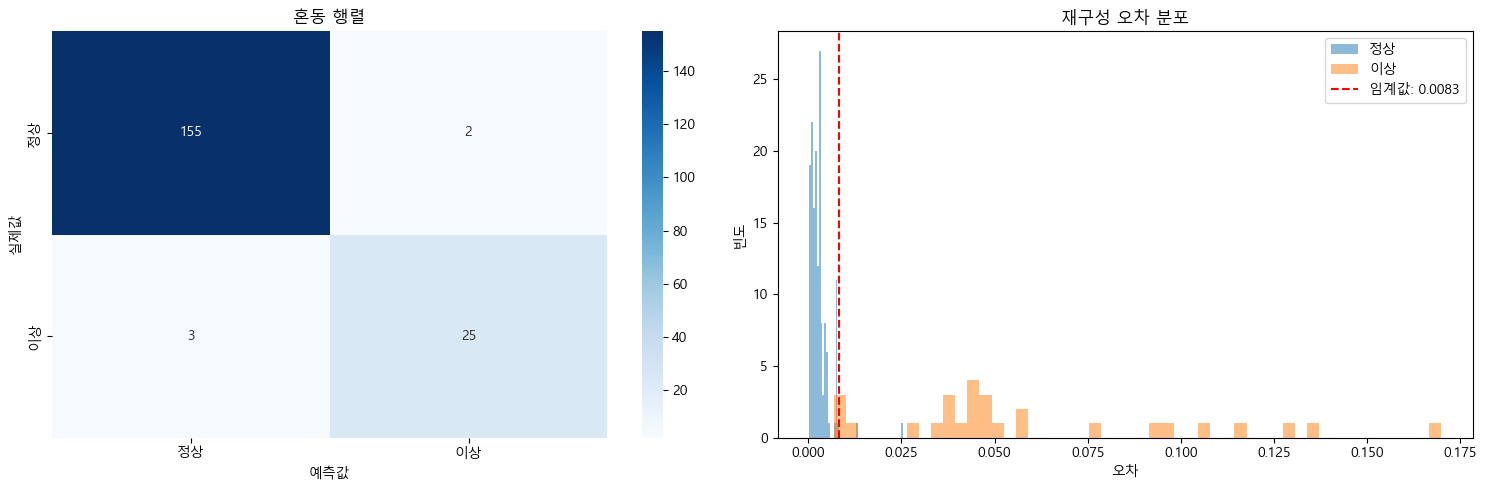

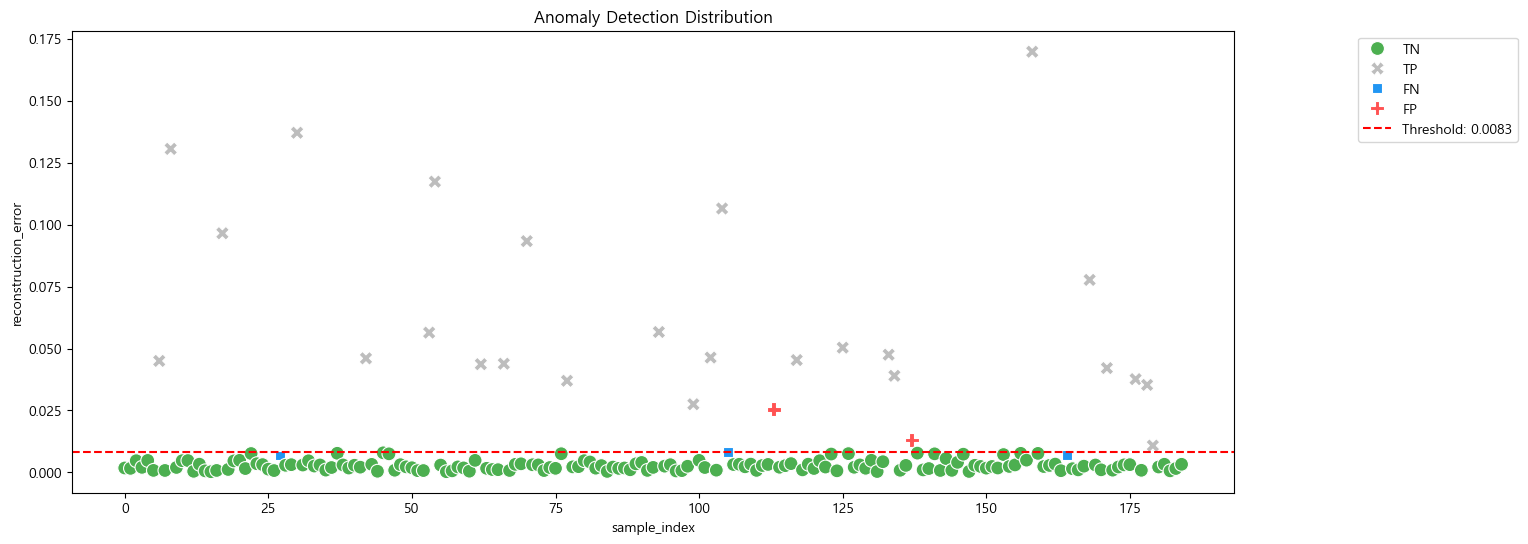

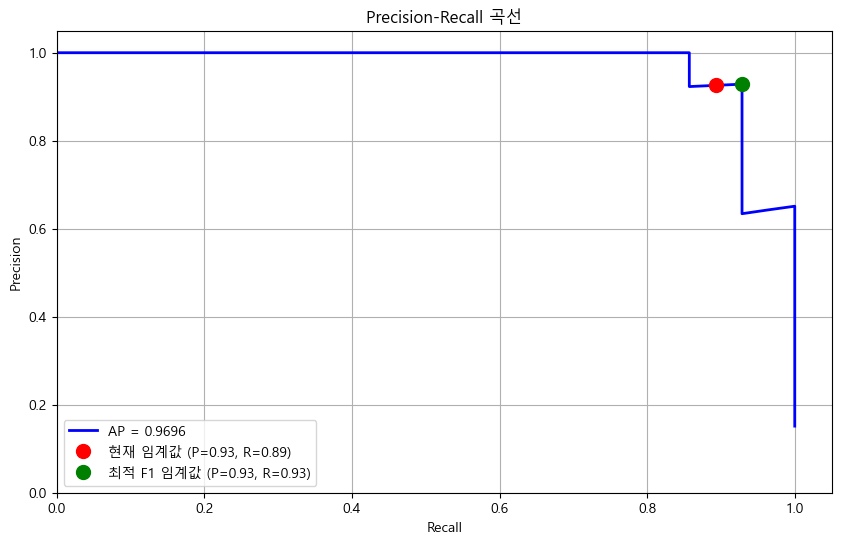

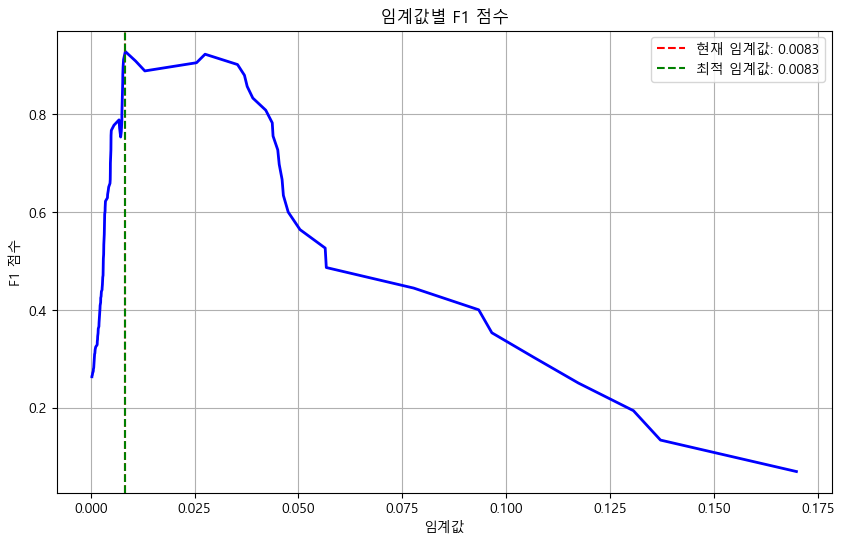

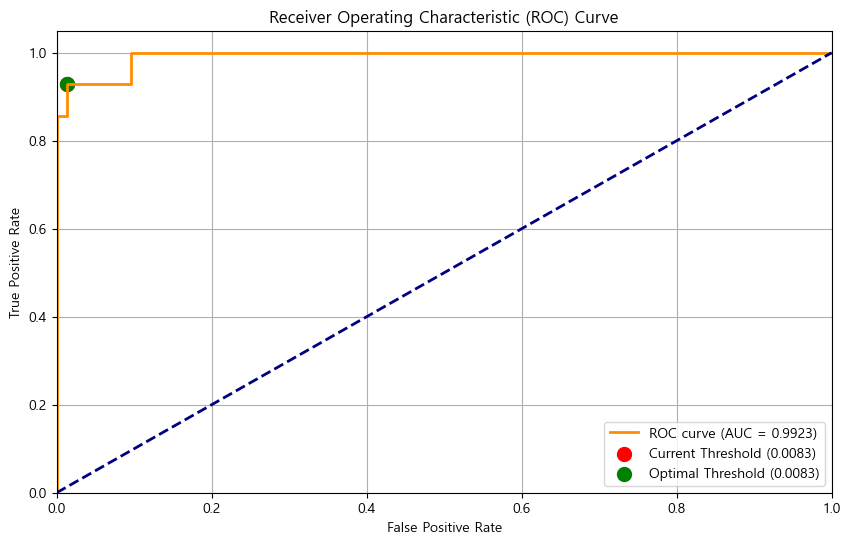


[최종 모델 성능 평가]
- Accuracy: 0.9730
- Precision: 0.9259
- Recall: 0.8929
- F1: 0.9091
- AUC: 0.9923


In [92]:
# 3. 성능 평가 함수 정의 (Precision-Recall 곡선 추가)
def evaluate_model_performance(model, test_scaled, test_labels):
    reconstructions = model.predict(test_scaled)
    reconstruction_errors = np.mean(np.square(test_scaled - reconstructions), axis=(1,2))

    # 임계값: 훈련 데이터 기준 95% 백분위
    precision, recall, pr_thresholds = precision_recall_curve(test_labels, reconstruction_errors)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    # 최적 F1 점수 임계값 찾기
    best_idx = np.argmax(f1_scores)
    best_threshold_test = pr_thresholds[best_idx] if best_idx < len(pr_thresholds) else pr_thresholds[-1]
    threshold = best_threshold_test
    #threshold = 0.0006

    predictions = (reconstruction_errors > threshold).astype(int)

    metrics = {
        'Accuracy': accuracy_score(test_labels, predictions),
        'Precision': precision_score(test_labels, predictions, zero_division=0),
        'Recall': recall_score(test_labels, predictions, zero_division=0),
        'F1': f1_score(test_labels, predictions, zero_division=0)
    }

    # 기존 시각화 코드 (1) - 혼동 행렬 및 재구성 오차 분포
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['정상', '이상'], 
                yticklabels=['정상', '이상'])
    plt.title('혼동 행렬')
    plt.xlabel('예측값')
    plt.ylabel('실제값')

    plt.subplot(1,2,2)
    plt.hist(reconstruction_errors[test_labels==0], bins=50, alpha=0.5, label='정상')
    plt.hist(reconstruction_errors[test_labels==1], bins=50, alpha=0.5, label='이상')
    plt.axvline(threshold, color='r', linestyle='--', label=f'임계값: {threshold:.4f}')
    plt.title('재구성 오차 분포')
    plt.xlabel('오차')
    plt.ylabel('빈도')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 기존 시각화 코드 (2) - 산점도
    plot_df = pd.DataFrame({
        'sample_index': range(len(test_labels)),
        'reconstruction_error': reconstruction_errors,
        'true_label': test_labels,
        'predicted_label': predictions
    })
    
    plot_df['type'] = 'TN'
    plot_df.loc[(plot_df['true_label']==1) & (plot_df['predicted_label']==1), 'type'] = 'TP'
    plot_df.loc[(plot_df['true_label']==0) & (plot_df['predicted_label']==1), 'type'] = 'FP'
    plot_df.loc[(plot_df['true_label']==1) & (plot_df['predicted_label']==0), 'type'] = 'FN'
    
    plt.figure(figsize=(15,6))
    sns.scatterplot(
        x='sample_index',
        y='reconstruction_error',
        hue='type',
        data=plot_df,
        palette={'TN':'#4CAF50', 'FP':'#FF5252', 'FN':'#2196F3', 'TP':'#BDBDBD'},
        style='type',
        s=100
    )
    plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.title('Anomaly Detection Distribution')
    plt.legend(bbox_to_anchor=(1.25, 1))
    plt.show()
    
    # 추가: Precision-Recall 곡선
    precision, recall, thresholds = precision_recall_curve(test_labels, reconstruction_errors)
    average_precision = average_precision_score(test_labels, reconstruction_errors)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, 'b-', linewidth=2, label=f'AP = {average_precision:.4f}')
    
    # 현재 임계값에 해당하는 정밀도/재현율 표시
    current_precision = metrics['Precision']
    current_recall = metrics['Recall']
    plt.plot(current_recall, current_precision, 'ro', markersize=10, 
             label=f'현재 임계값 (P={current_precision:.2f}, R={current_recall:.2f})')
    
    # 최적 F1 점수 임계값 찾기
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    
    plt.plot(recall[best_idx], precision[best_idx], 'go', markersize=10,
             label=f'최적 F1 임계값 (P={precision[best_idx]:.2f}, R={recall[best_idx]:.2f})')
    
    plt.title('Precision-Recall 곡선')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 임계값별 F1 점수 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores[:-1], 'b-', linewidth=2)
    plt.axvline(threshold, color='r', linestyle='--', label=f'현재 임계값: {threshold:.4f}')
    plt.axvline(best_threshold, color='g', linestyle='--', label=f'최적 임계값: {best_threshold:.4f}')
    plt.title('임계값별 F1 점수')
    plt.xlabel('임계값')
    plt.ylabel('F1 점수')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 추가: AUC-ROC 곡선 계산 및 시각화
    # ROC 곡선 계산
    fpr, tpr, roc_thresholds = roc_curve(test_labels, reconstruction_errors)
    roc_auc = roc_auc_score(test_labels, reconstruction_errors)
    
    # ROC 곡선 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # 현재 임계값 위치 표시
    current_fpr = fpr[np.argmin(np.abs(roc_thresholds - threshold))]
    current_tpr = tpr[np.argmin(np.abs(roc_thresholds - threshold))]
    plt.scatter(current_fpr, current_tpr, color='red', s=100, 
                label=f'Current Threshold ({threshold:.4f})')
    
    # 최적 임계값(Youden's J 통계량)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = roc_thresholds[optimal_idx]
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='green', s=100,
                label=f'Optimal Threshold ({optimal_threshold:.4f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # 메트릭스 업데이트
    metrics['AUC'] = roc_auc
    
    return metrics

# 함수 호출
performance = evaluate_model_performance(model, shuffled_test_scaled, shuffled_test_labels)

# 성능 지표 출력
print("\n[최종 모델 성능 평가]")
for metric, value in performance.items():
    print(f"- {metric}: {value:.4f}")
#가나다라

In [93]:
def mi_fgsm_attack_timeseries(model, x, eps=0.1, alpha=0.01, iters=10, decay=1.0, targeted=False):
    """
    시계열 데이터(3D)용 MI-FGSM 공격 함수
    
    매개변수:
    - model: 훈련된 LSTM-AE 모델 (입력/출력 형태: [batch, time_steps, features])
    - x: 원본 입력 데이터 (numpy array, [batch, time_steps, features])
    - eps: 최대 교란 크기 (MinMax 스케일링 기준 0~1)
    - alpha: 스텝 크기
    - iters: 반복 횟수
    - decay: 모멘텀 감쇠 계수
    - targeted: 타겟 공격 여부 (False일 경우 비정상치 생성)
    
    반환값:
    - adv_x: 적대적 샘플 (numpy array)
    - perturbation: 적용된 노이즈 (numpy array)
    """
    
    # TensorFlow 텐서로 변환
    x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
    
    # 노이즈 초기화
    perturbation = tf.random.uniform(shape=x.shape, minval=-eps, maxval=eps, dtype=tf.float32)
    momentum = tf.zeros_like(x_tf)
    
    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(perturbation) #perturbation을 미분 대상으로 지정
            
            # 현재 교란된 입력
            current = tf.clip_by_value(x_tf + perturbation, 0.0, 1.0) #x + 노이즈(perturbation), 범위: 0.0~1.0
            
            # 재구성 오차 계산 (LSTM-AE용)
            recon = model(current) #모델의 판단 결과
            loss = tf.reduce_mean(tf.square(recon - current))  # MSE 손실(비용함수)
            
            if targeted:
                loss = -loss  # 타겟 공격 시 손실 최소화

        # 그래디언트 계산
        grad = tape.gradient(loss, perturbation) #비용함수에 대한 perturbation의 그래디언트 == grad
        
        # 그래디언트 정규화 (L1 norm)
        grad_norm = tf.norm(tf.reshape(grad, [x.shape[0], -1]), ord=1, axis=1)
        grad_norm = tf.reshape(grad_norm, [-1, 1, 1])
        grad_normalized = grad / (grad_norm + 1e-10)
        
        # 모멘텀 업데이트
        momentum = decay * momentum + grad_normalized
        
        # 노이즈 업데이트
        if targeted:
            perturbation = perturbation - alpha * tf.sign(momentum)
        else:
            perturbation = perturbation + alpha * tf.sign(momentum)
        
        # 노이즈 클리핑
        perturbation = tf.clip_by_value(perturbation, -eps, eps)
    
    # 최종 적대적 샘플 생성
    adv_x = tf.clip_by_value(x_tf + perturbation, 0.0, 1.0).numpy()
    return adv_x, perturbation.numpy()

adv_data, perturbation_data = mi_fgsm_attack_timeseries(model, train_scaled)
np.save('adv_data.npy', adv_data)
np.save('perturbation_data.npy', perturbation_data)
print(adv_data, adv_data.shape)

[[[0.22988158 0.14727286 0.24934612 ... 0.93409276 0.6218698  1.        ]]

 [[0.5317253  0.56764215 0.57723105 ... 0.7061161  0.3158605  1.        ]]

 [[0.8503683  1.         0.8471765  ... 1.         0.43333334 0.        ]]

 ...

 [[0.54669154 0.33818096 0.53897995 ... 0.69505554 0.28764874 1.        ]]

 [[0.74705905 0.74545467 0.73752236 ... 0.9783346  0.         0.02000001]]

 [[0.6628673  0.652726   0.8468121  ... 1.         1.         1.        ]]] (728, 1, 98)


In [94]:
import numpy as np

# 1. 적대적 샘플 100개 추출 (시드 42 고정)
np.random.seed(seed)
indices = np.random.choice(adv_data.shape[0], 100, replace=False)
adv_test_data = adv_data[indices]  # (100, 1, 98)

# 2. 데이터셋 결합
combined_test_data = np.concatenate([test_scaled, adv_test_data], axis=0)  # (500+100, 1, 98)
combined_test_labels = np.concatenate([test_labels, np.ones(100)], axis=0)  # (500+100,)

# 3. 동일한 순서로 셔플링
shuffled_indices = np.random.permutation(len(combined_test_labels))
final_test_data = combined_test_data[shuffled_indices]
final_test_labels = combined_test_labels[shuffled_indices]

# 결과 확인
print("┌──────────────────────────────┐")
print("│       Dataset Information     │")
print("├──────────────────────────────┤")
print(f"│ Combined Data Shape: {combined_test_data.shape} │")
print(f"│ Final Data Shape: {final_test_data.shape} │")
print(f"│ Label Distribution: {np.unique(final_test_labels, return_counts=True)} │")
print("└──────────────────────────────┘")


┌──────────────────────────────┐
│       Dataset Information     │
├──────────────────────────────┤
│ Combined Data Shape: (285, 1, 98) │
│ Final Data Shape: (285, 1, 98) │
│ Label Distribution: (array([0., 1.]), array([157, 128])) │
└──────────────────────────────┘


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


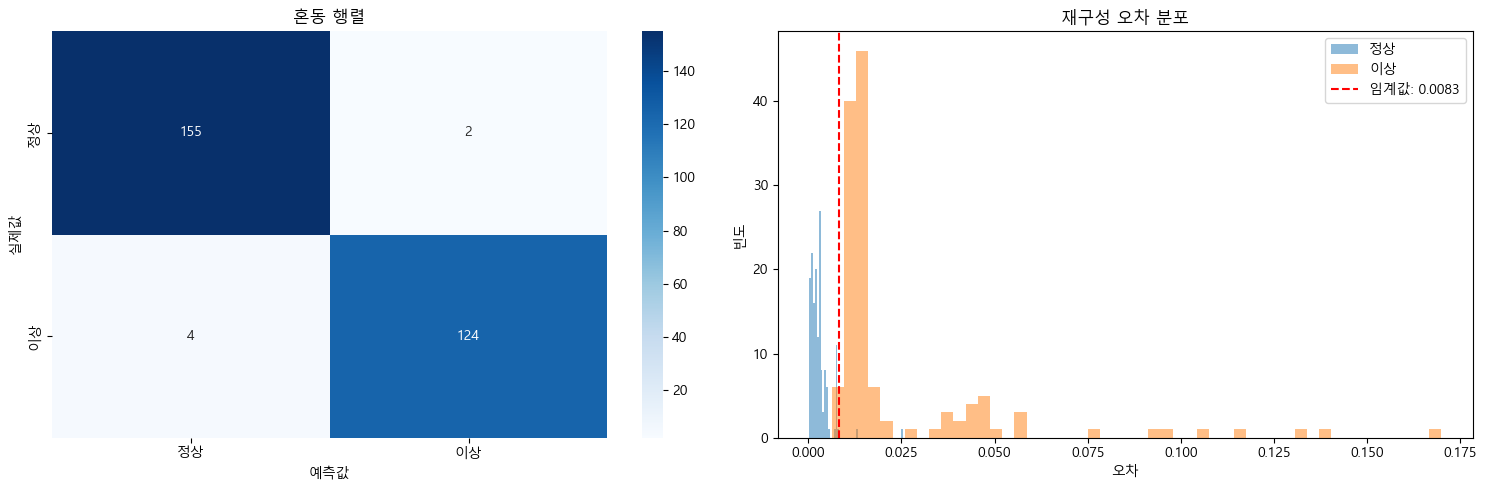

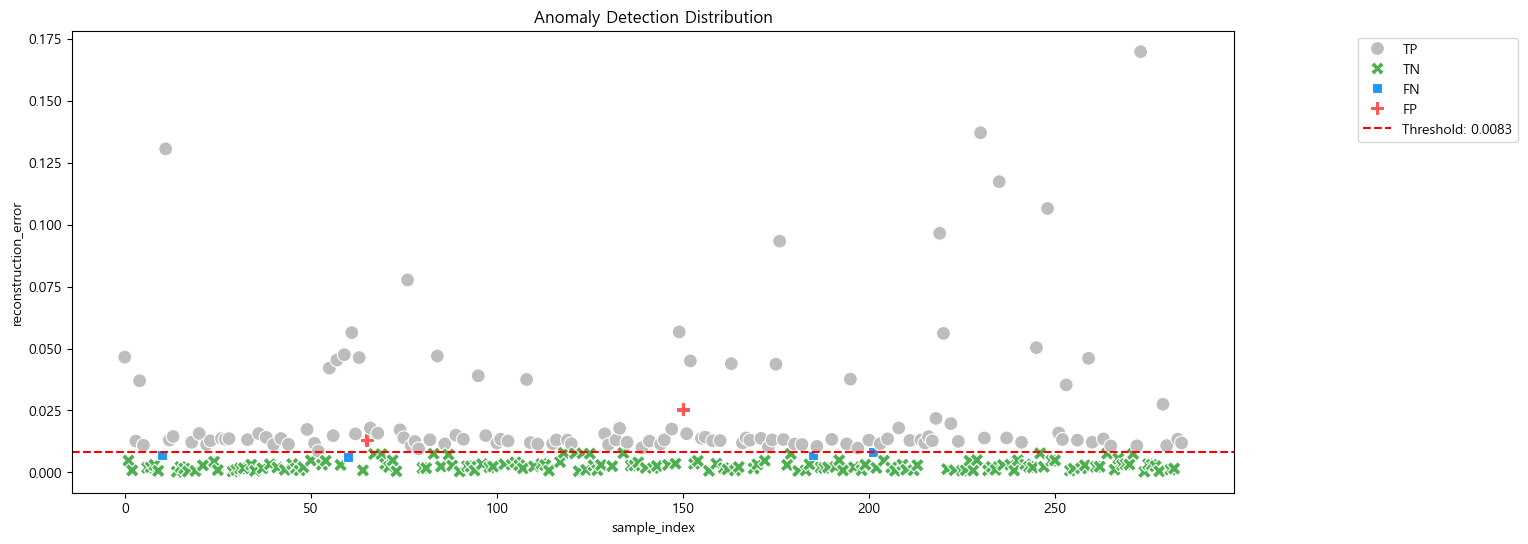

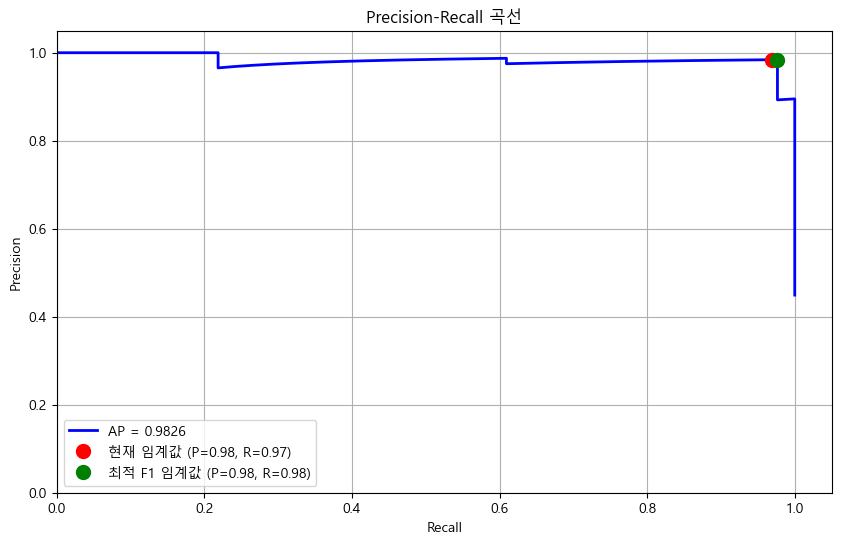

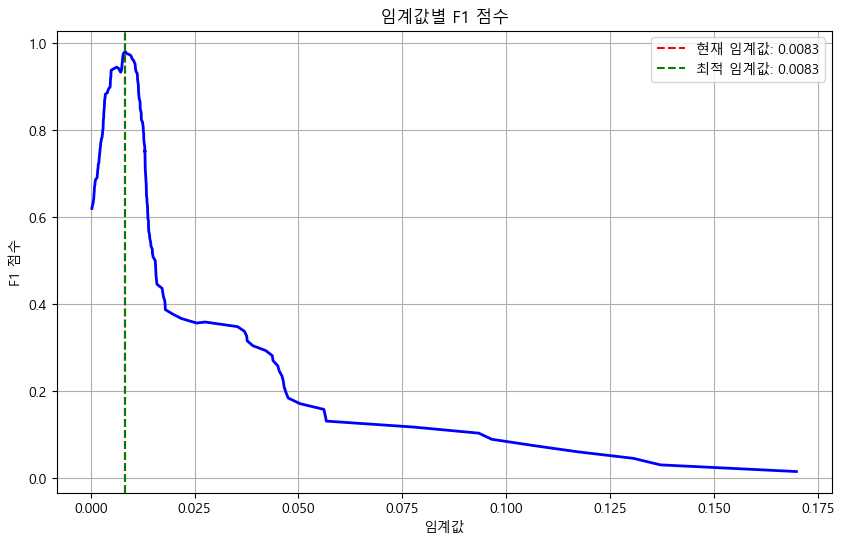

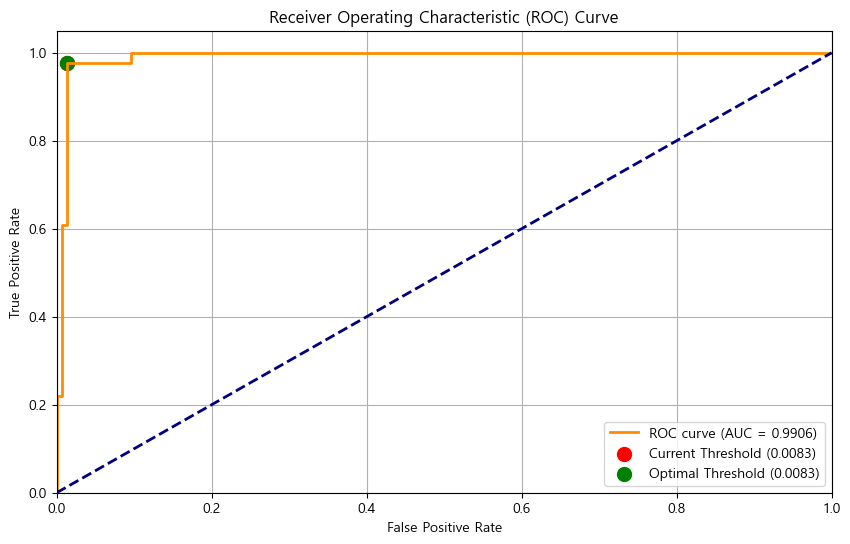


[최종 모델 성능 평가]
- Accuracy: 0.9789
- Precision: 0.9841
- Recall: 0.9688
- F1: 0.9764
- AUC: 0.9906


In [95]:
# 3. 성능 평가 함수 정의 (Precision-Recall 곡선 추가)
def evaluate_model_performance(model, test_scaled, test_labels):
    reconstructions = model.predict(test_scaled)
    reconstruction_errors = np.mean(np.square(test_scaled - reconstructions), axis=(1,2))

    # 임계값: 훈련 데이터 기준 95% 백분위
    precision, recall, pr_thresholds = precision_recall_curve(test_labels, reconstruction_errors)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    # 최적 F1 점수 임계값 찾기
    best_idx = np.argmax(f1_scores)
    best_threshold_test = pr_thresholds[best_idx] if best_idx < len(pr_thresholds) else pr_thresholds[-1]
    threshold = best_threshold_test
    #threshold = 0.0006

    predictions = (reconstruction_errors > threshold).astype(int)

    metrics = {
        'Accuracy': accuracy_score(test_labels, predictions),
        'Precision': precision_score(test_labels, predictions, zero_division=0),
        'Recall': recall_score(test_labels, predictions, zero_division=0),
        'F1': f1_score(test_labels, predictions, zero_division=0)
    }

    # 기존 시각화 코드 (1) - 혼동 행렬 및 재구성 오차 분포
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['정상', '이상'], 
                yticklabels=['정상', '이상'])
    plt.title('혼동 행렬')
    plt.xlabel('예측값')
    plt.ylabel('실제값')

    plt.subplot(1,2,2)
    plt.hist(reconstruction_errors[test_labels==0], bins=50, alpha=0.5, label='정상')
    plt.hist(reconstruction_errors[test_labels==1], bins=50, alpha=0.5, label='이상')
    plt.axvline(threshold, color='r', linestyle='--', label=f'임계값: {threshold:.4f}')
    plt.title('재구성 오차 분포')
    plt.xlabel('오차')
    plt.ylabel('빈도')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 기존 시각화 코드 (2) - 산점도
    plot_df = pd.DataFrame({
        'sample_index': range(len(test_labels)),
        'reconstruction_error': reconstruction_errors,
        'true_label': test_labels,
        'predicted_label': predictions
    })
    
    plot_df['type'] = 'TN'
    plot_df.loc[(plot_df['true_label']==1) & (plot_df['predicted_label']==1), 'type'] = 'TP'
    plot_df.loc[(plot_df['true_label']==0) & (plot_df['predicted_label']==1), 'type'] = 'FP'
    plot_df.loc[(plot_df['true_label']==1) & (plot_df['predicted_label']==0), 'type'] = 'FN'
    
    plt.figure(figsize=(15,6))
    sns.scatterplot(
        x='sample_index',
        y='reconstruction_error',
        hue='type',
        data=plot_df,
        palette={'TN':'#4CAF50', 'FP':'#FF5252', 'FN':'#2196F3', 'TP':'#BDBDBD'},
        style='type',
        s=100
    )
    plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.title('Anomaly Detection Distribution')
    plt.legend(bbox_to_anchor=(1.25, 1))
    plt.show()
    
    # 추가: Precision-Recall 곡선
    precision, recall, thresholds = precision_recall_curve(test_labels, reconstruction_errors)
    average_precision = average_precision_score(test_labels, reconstruction_errors)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, 'b-', linewidth=2, label=f'AP = {average_precision:.4f}')
    
    # 현재 임계값에 해당하는 정밀도/재현율 표시
    current_precision = metrics['Precision']
    current_recall = metrics['Recall']
    plt.plot(current_recall, current_precision, 'ro', markersize=10, 
             label=f'현재 임계값 (P={current_precision:.2f}, R={current_recall:.2f})')
    
    # 최적 F1 점수 임계값 찾기
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    
    plt.plot(recall[best_idx], precision[best_idx], 'go', markersize=10,
             label=f'최적 F1 임계값 (P={precision[best_idx]:.2f}, R={recall[best_idx]:.2f})')
    
    plt.title('Precision-Recall 곡선')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 임계값별 F1 점수 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores[:-1], 'b-', linewidth=2)
    plt.axvline(threshold, color='r', linestyle='--', label=f'현재 임계값: {threshold:.4f}')
    plt.axvline(best_threshold, color='g', linestyle='--', label=f'최적 임계값: {best_threshold:.4f}')
    plt.title('임계값별 F1 점수')
    plt.xlabel('임계값')
    plt.ylabel('F1 점수')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 추가: AUC-ROC 곡선 계산 및 시각화
    # ROC 곡선 계산
    fpr, tpr, roc_thresholds = roc_curve(test_labels, reconstruction_errors)
    roc_auc = roc_auc_score(test_labels, reconstruction_errors)
    
    # ROC 곡선 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # 현재 임계값 위치 표시
    current_fpr = fpr[np.argmin(np.abs(roc_thresholds - threshold))]
    current_tpr = tpr[np.argmin(np.abs(roc_thresholds - threshold))]
    plt.scatter(current_fpr, current_tpr, color='red', s=100, 
                label=f'Current Threshold ({threshold:.4f})')
    
    # 최적 임계값(Youden's J 통계량)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = roc_thresholds[optimal_idx]
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='green', s=100,
                label=f'Optimal Threshold ({optimal_threshold:.4f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # 메트릭스 업데이트
    metrics['AUC'] = roc_auc
    
    return metrics

# 함수 호출
performance = evaluate_model_performance(model, final_test_data, final_test_labels)

# 성능 지표 출력
print("\n[최종 모델 성능 평가]")
for metric, value in performance.items():
    print(f"- {metric}: {value:.4f}")
